In [1]:
from shapely.geometry import Polygon
import pandas as pd

# Import imageloader
import rasterio
import cv2

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

%matplotlib inline
%reload_ext autoreload

## Read the dataset

In [2]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_mask, mask_to_polygons

(832, 832, 3)


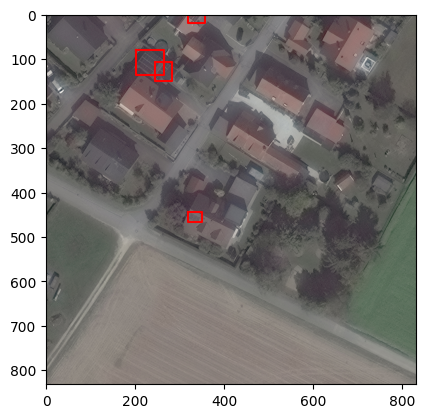

In [3]:
file = os.listdir('germany_dataset/labels')[0]
image, polygons = load_image_and_labels(file)

print(image.shape)

# Plot the image with the polygons drawn in
def plot_image_and_labels(image, polygons):
    # Convert the image to a numpy array
    image = np.array(image)

    for polygon in polygons:
        x, y = polygon.exterior.xy
        plt.plot(x, y, c='r')
        
    # Plot the image
    plt.imshow(image)
    plt.show()
    
plot_image_and_labels(image, polygons)

(832, 832, 1)


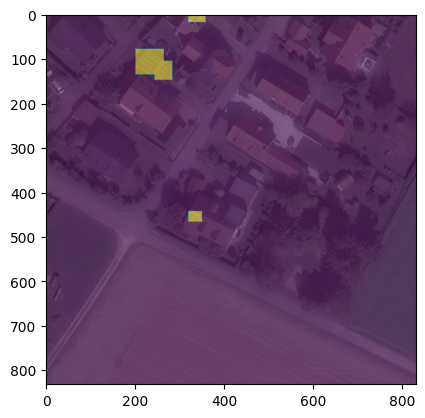

In [4]:
# Plot the mask and the images in the same plot
mask = polygons_to_mask(polygons)
bounding_boxes = polygons_to_bounding_boxes(polygons)

def plot_image_and_mask(image, mask):
    
    # Convert the image to a numpy array
    image = np.array(image)

    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    
    plt.show()
    
print(mask.shape)
plot_image_and_mask(image, mask)


### Load the dataset

In [5]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataloaders.germany_dataset import GermanyDataset

In [6]:
# From the dataset, create a train and test set
dataset = os.listdir('germany_dataset/labels')

train, test = train_test_split(dataset, test_size=0.2)

train_dataset = GermanyDataset(train)
test_dataset = GermanyDataset(test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Train the model

In [7]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [8]:
# model = DeepLabModel(input_size=832, num_classes=2)
model = UNetModel(n_channels=3, n_classes=1)

# model = MaskRCNNModel(num_classes=2)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

base_model = BaseModel(model, loss_fn, optimizer)
trainer = pl.Trainer(max_epochs=10, min_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
# for image, label in train_loader:
#     # Print the size of the image and label
#     print(image.size(), label)  
#     break

In [10]:
trainer.fit(base_model, train_loader)

/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNetModel        | 31.0 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)
/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([1, 2, 832, 832])
torch.Size([1, 832, 832])


RuntimeError: expected scalar type Long but found Float

In [ ]:
# Estimate the model on the test set
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        output = model(image)
                
        # Convert the output to a polygon
        polygons = []
        for mask in output["masks"]:
            polygons.extend(mask_to_polygons(mask.numpy()))
        
        # Reshape image into 832x832
        image = image.view(832, 832, 3)
        
        # Plot the image and the polygons
        plot_image_and_labels(image, polygons)
        
        break
        